# Prova Final - Machine Learning

**Nome do aluno**: <font color='red'>LUIGI CARMONA DE MIRANDA LOPES</font>

Você deve submeter o trabalho via Blackboard. É de sua responsabilidade garantir que o arquivo correto foi enviado.

Se você precisou adicionar arquivos extras à essa prova, assegure-se de que você os está enviando também.

A prova é individual e com consulta - pode consultar suas anotações, a web, o que quiser, menos perguntar para outros ou para as AIs. Faça o seu trabalho de maneira ética!

ChatGPT para perguntas teóricas não é permitido. CoPilot para código é permitido.

## Instruções

Nesta prova vamos trabalhar com um dataset de informações acerca dos hábitos de pessoas que frequentam uma academia de ginástica.

As questões estão distribuidas ao longo do notebook, procure pela tag "**QUESTÕES**". Temos 5 questões ao todo, com vários sub-itens, somando 11 pontos! (Mas a prova satura em 10, ok?)

Boa prova!

***

# Parte 1: leitura de dados, separação treino-teste, EDA

Não temos questões nessa parte.

### Leitura dos dados

In [1]:
# Código para leitura dos dado, não esqueça de rodar!

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display


def read_data() -> tuple[pd.DataFrame, list[str], list[str], str]:
    """
    Lê o dataset de treino de membros da academia e retorna o DataFrame, 
    colunas categóricas, colunas numéricas e a coluna alvo.
    """
    cat_columns = [
        'Gender',
        'Workout_Type',
        'Experience_Level',
    ]
    num_columns = [
        'Weight (kg)',
        'Height (m)',
        'Max_BPM',
        'Avg_BPM',
        'Resting_BPM',
        'Session_Duration (hours)',
        'Fat_Percentage',
        'Water_Intake (liters)',
        'Workout_Frequency (days/week)',
        'BMI',
    ]
    target_column = 'Calories_Burned'
    dataset = pd.read_csv('gym_members_exercise_tracking.csv')
    return dataset, cat_columns, num_columns, target_column

In [2]:
dataset, cat_columns, num_columns, target_column = read_data()

### Separação treino-teste

In [3]:
from sklearn.model_selection import train_test_split

SEED = 42
test_size = 0.2

train_dataset, test_dataset = train_test_split(
    dataset,
    test_size=test_size,
    random_state=SEED,
)

### EDA

In [4]:
for column in cat_columns:
    display(dataset[column].value_counts().sort_index())

Gender
Female    462
Male      511
Name: count, dtype: int64

Workout_Type
Cardio      255
HIIT        221
Strength    258
Yoga        239
Name: count, dtype: int64

Experience_Level
1    376
2    406
3    191
Name: count, dtype: int64

In [5]:
display(dataset[num_columns] \
    .describe() \
    .transpose() \
    .style \
    .format({ \
        'mean': '{:.2f}', \
        'std': '{:.2f}', \
        'min': '{:.2f}', \
        '25%': '{:.2f}', \
        '50%': '{:.2f}', \
        '75%': '{:.2f}', \
        'max': '{:.2f}', \
    }) \
    .set_table_attributes('style="width: 50%;"'))


,count,mean,std,min,25%,50%,75%,max
Weight (kg),973.000000,73.85,21.21,40.00,58.10,70.00,86.00,129.90
Height (m),973.000000,1.72,0.13,1.50,1.62,1.71,1.80,2.00
Max_BPM,973.000000,179.88,11.53,160.00,170.00,180.00,190.00,199.00
Avg_BPM,973.000000,143.77,14.35,120.00,131.00,143.00,156.00,169.00
Resting_BPM,973.000000,62.22,7.33,50.00,56.00,62.00,68.00,74.00
Session_Duration (hours),973.000000,1.26,0.34,0.50,1.04,1.26,1.46,2.00
Fat_Percentage,973.000000,24.98,6.26,10.00,21.30,26.20,29.30,35.00
Water_Intake (liters),973.000000,2.63,0.60,1.50,2.20,2.60,3.10,3.70
Workout_Frequency (days/week),973.000000,3.32,0.91,2.00,3.00,3.00,4.00,5.00
BMI,973.000000,24.91,6.66,12.32,20.11,24.16,28.56,49.84


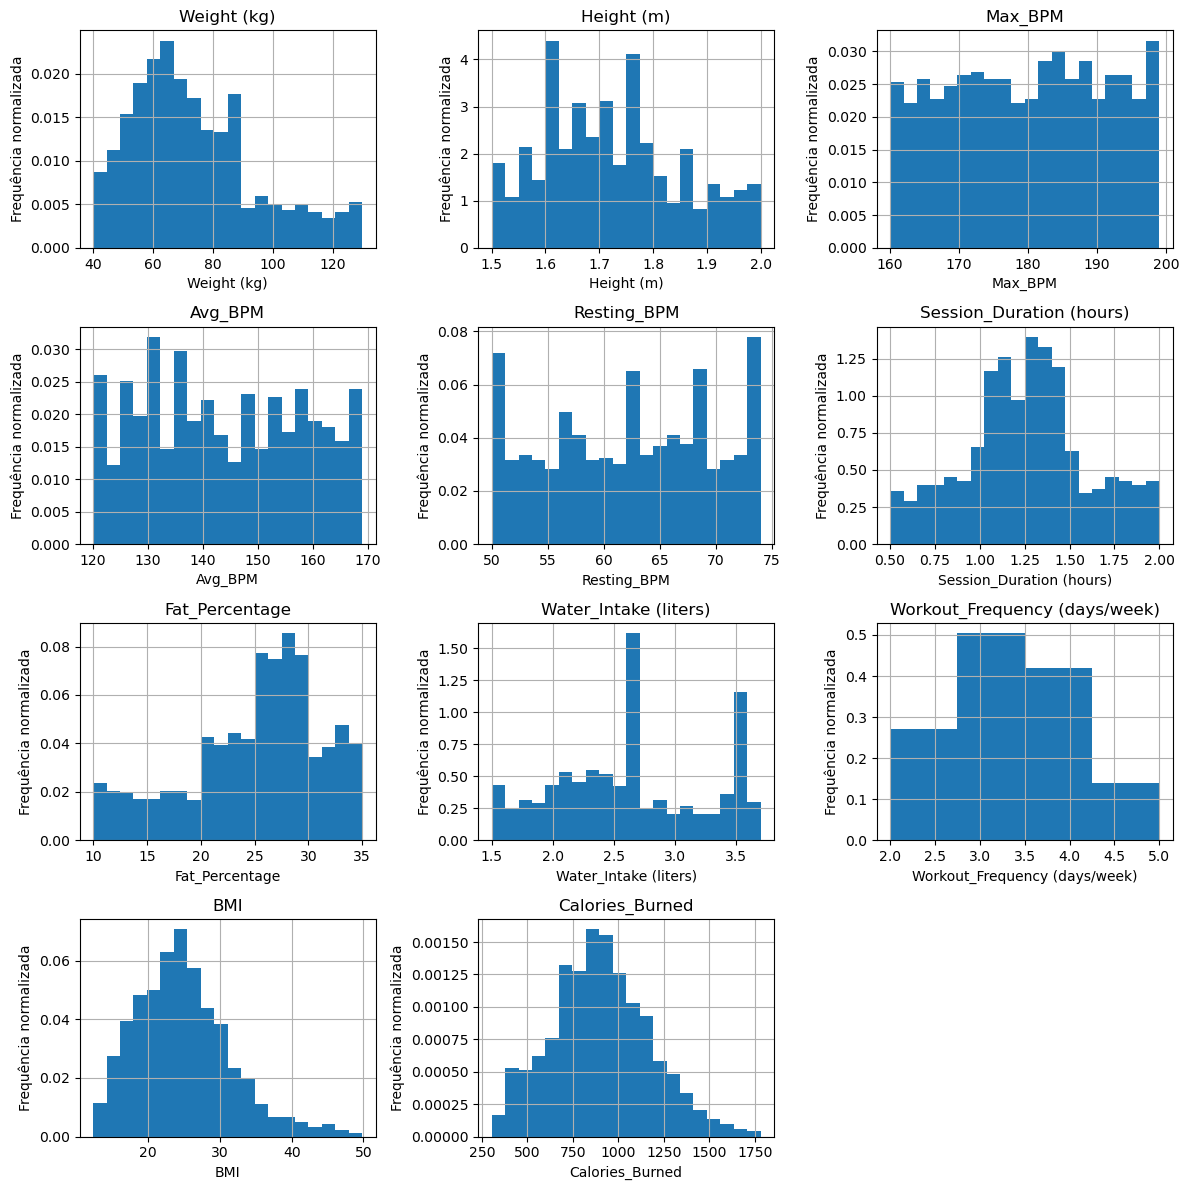

In [6]:
plt.figure(figsize=(12, 12))
for i, column in enumerate(num_columns + [target_column]):
    plt.subplot(4, 3, i + 1)
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel('Frequência normalizada')
    plt.grid()
    plt.hist(
        dataset[column],
        bins=min(20, len(dataset[column].unique())),
        density=True,
    )
plt.tight_layout()
plt.show()


In [7]:
display(train_dataset[num_columns + [target_column]] \
    .corr() \
    .style \
    .background_gradient(cmap='coolwarm', axis=None) \
    .set_table_attributes('style="width: 50%;"') \
    .set_caption('Correlação entre variáveis numéricas'))

,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),BMI,Calories_Burned
Weight (kg),1.000000,0.372351,0.049328,-0.011073,-0.013469,-0.011101,-0.234515,0.408174,0.005948,0.849798,0.095226
Height (m),0.372351,1.000000,-0.057417,-0.017122,-0.000547,-0.009226,-0.238102,0.391995,0.001349,-0.157753,0.087870
Max_BPM,0.049328,-0.057417,1.000000,-0.042396,0.027311,0.030093,-0.013544,0.030548,-0.021016,0.083389,0.019129
Avg_BPM,-0.011073,-0.017122,-0.042396,1.000000,0.070027,0.028216,-0.020048,-0.003184,-0.001472,-0.002203,0.344800
Resting_BPM,-0.013469,-0.000547,0.027311,0.070027,1.000000,0.023454,-0.031448,0.053768,0.020149,-0.013961,0.065211
Session_Duration (hours),-0.011101,-0.009226,0.030093,0.028216,0.023454,1.000000,-0.578470,0.254766,0.639245,-0.003247,0.909383
Fat_Percentage,-0.234515,-0.238102,-0.013544,-0.020048,-0.031448,-0.578470,1.000000,-0.586133,-0.536769,-0.125843,-0.603095
Water_Intake (liters),0.408174,0.391995,0.030548,-0.003184,0.053768,0.254766,-0.586133,1.000000,0.233791,0.229339,0.334206
Workout_Frequency (days/week),0.005948,0.001349,-0.021016,-0.001472,0.020149,0.639245,-0.536769,0.233791,1.000000,0.013200,0.578198
BMI,0.849798,-0.157753,0.083389,-0.002203,-0.013961,-0.003247,-0.125843,0.229339,0.013200,1.000000,0.058568


In [8]:
for column in cat_columns:
    display(train_dataset[num_columns + [target_column, column]] \
        .groupby(column) \
        .mean() \
        .sort_values(target_column) \
        .style \
        .format(precision=2) \
        .set_table_attributes('style="width: 50%;"') \
        .background_gradient(cmap='coolwarm', axis=0) \
        .set_caption(f'Média de {target_column} por {column}'))


,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),BMI,Calories_Burned
Gender,,,,,,,,,,,
Female,60.69,1.64,180.00,143.52,62.04,1.27,27.74,2.21,3.34,22.62,864.50
Male,84.92,1.80,179.74,143.52,62.35,1.25,22.65,3.02,3.33,26.61,938.78


,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),BMI,Calories_Burned
Workout_Type,,,,,,,,,,,
Cardio,74.52,1.72,180.02,143.53,61.59,1.23,25.48,2.64,3.24,25.22,888.52
Yoga,72.89,1.74,180.36,143.39,61.69,1.25,24.59,2.63,3.35,24.08,895.78
Strength,71.96,1.72,179.07,143.74,62.58,1.26,25.57,2.60,3.39,24.40,909.45
HIIT,75.09,1.72,180.12,143.38,62.98,1.29,24.33,2.70,3.36,25.26,923.98


,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),BMI,Calories_Burned
Experience_Level,,,,,,,,,,,
1,72.96,1.73,180.42,143.29,62.07,1.01,27.67,2.55,2.51,24.45,724.78
2,74.15,1.72,178.86,143.71,62.05,1.25,27.32,2.50,3.53,25.04,903.50
3,73.56,1.73,180.98,143.56,62.82,1.75,14.70,3.13,4.54,24.68,1263.68


In [9]:
for column_1 in cat_columns:
    for column_2 in cat_columns:
        if column_1 == column_2:
            continue
        display(pd.crosstab(
            train_dataset[column_1],
            train_dataset[column_2],
            normalize='columns',
        ).style \
            .background_gradient(cmap='coolwarm', axis=0) \
            .set_table_attributes('style="width: 50%;"') \
            .set_caption(f'Porcentagem de {column_1} por {column_2}'))


Workout_Type,Cardio,HIIT,Strength,Yoga
Gender,,,,
Female,0.483254,0.469274,0.478673,0.435754
Male,0.516746,0.530726,0.521327,0.564246


Experience_Level,1,2,3
Gender,,,
Female,0.479866,0.459215,0.463087
Male,0.520134,0.540785,0.536913


Gender,Female,Male
Workout_Type,,
Cardio,0.277473,0.260870
HIIT,0.230769,0.229469
Strength,0.277473,0.265700
Yoga,0.214286,0.243961


Experience_Level,1,2,3
Workout_Type,,,
Cardio,0.295302,0.253776,0.248322
HIIT,0.234899,0.208459,0.268456
Strength,0.261745,0.293051,0.241611
Yoga,0.208054,0.244713,0.241611


Gender,Female,Male
Experience_Level,,
1,0.392857,0.374396
2,0.417582,0.432367
3,0.189560,0.193237


Workout_Type,Cardio,HIIT,Strength,Yoga
Experience_Level,,,,
1,0.421053,0.391061,0.369668,0.346369
2,0.401914,0.385475,0.459716,0.452514
3,0.177033,0.223464,0.170616,0.201117


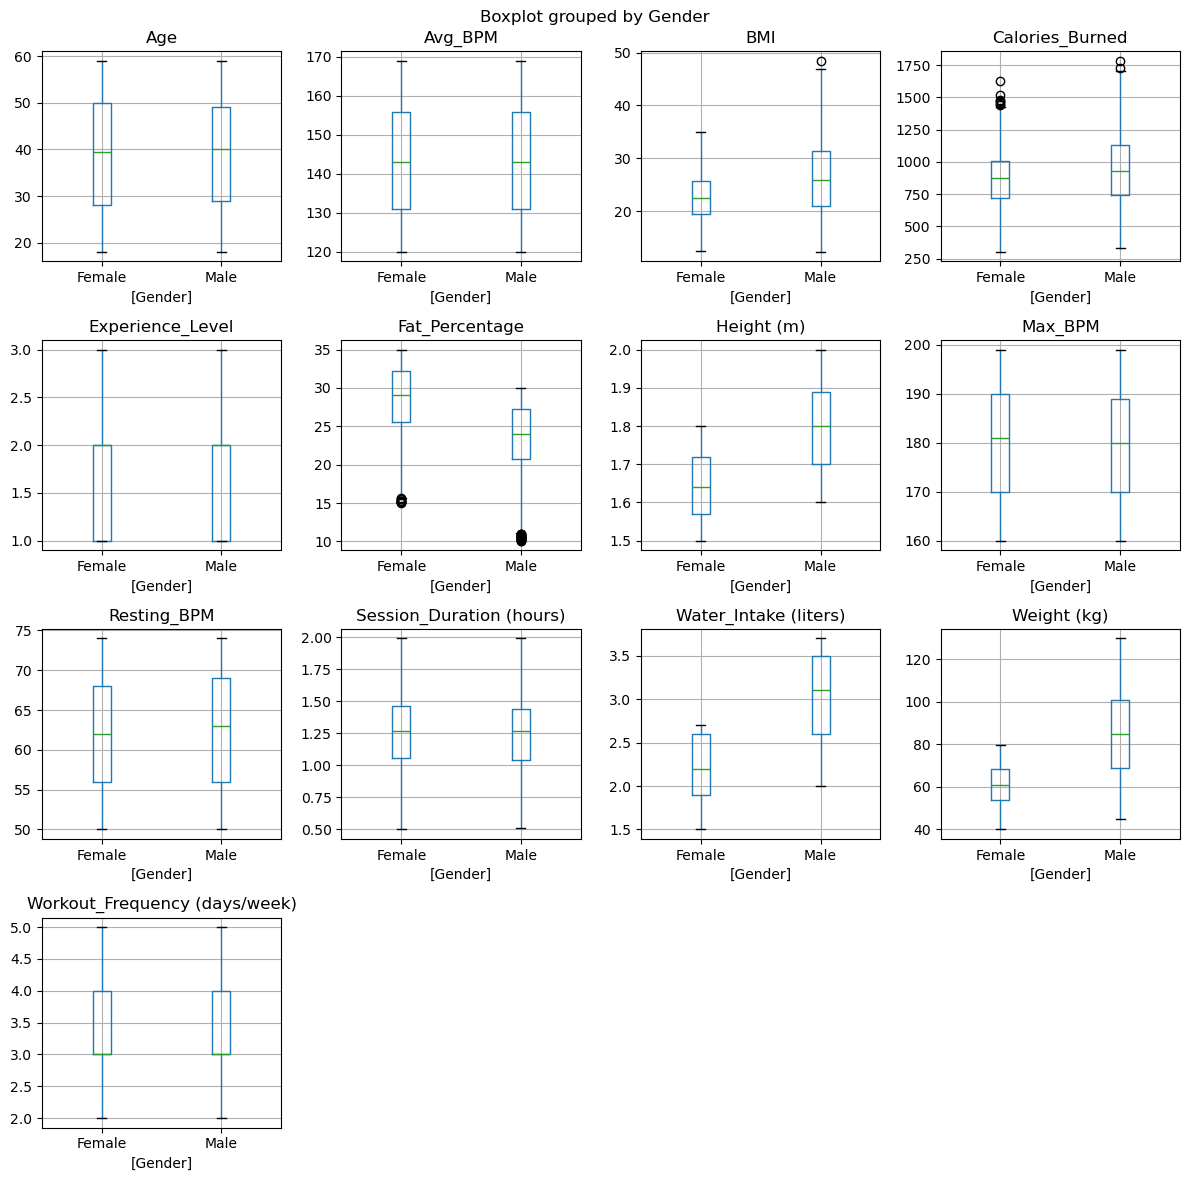

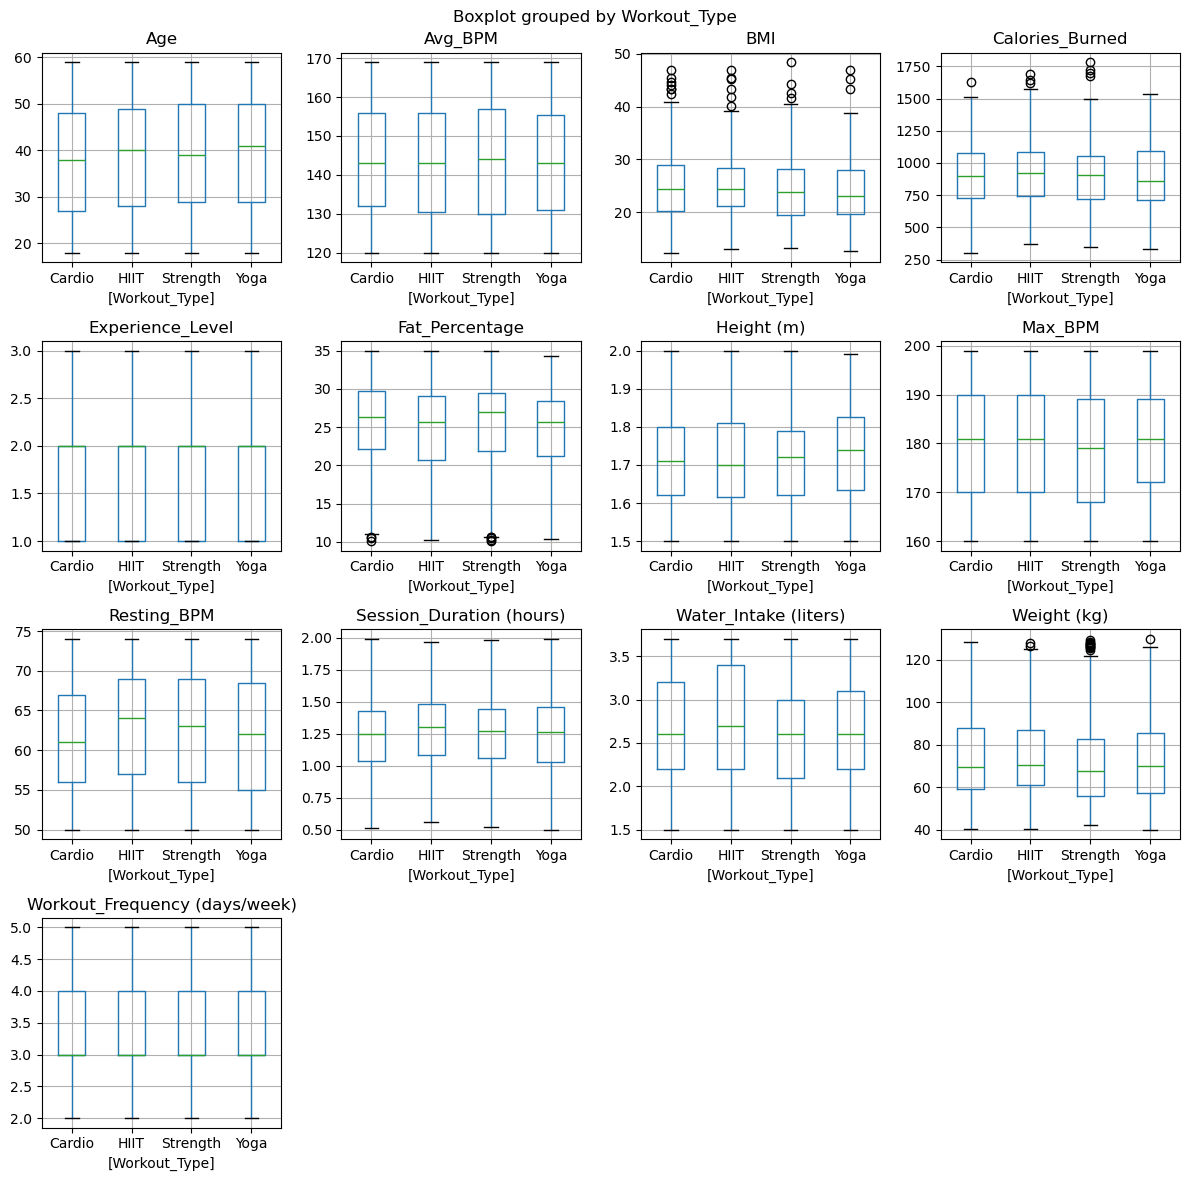

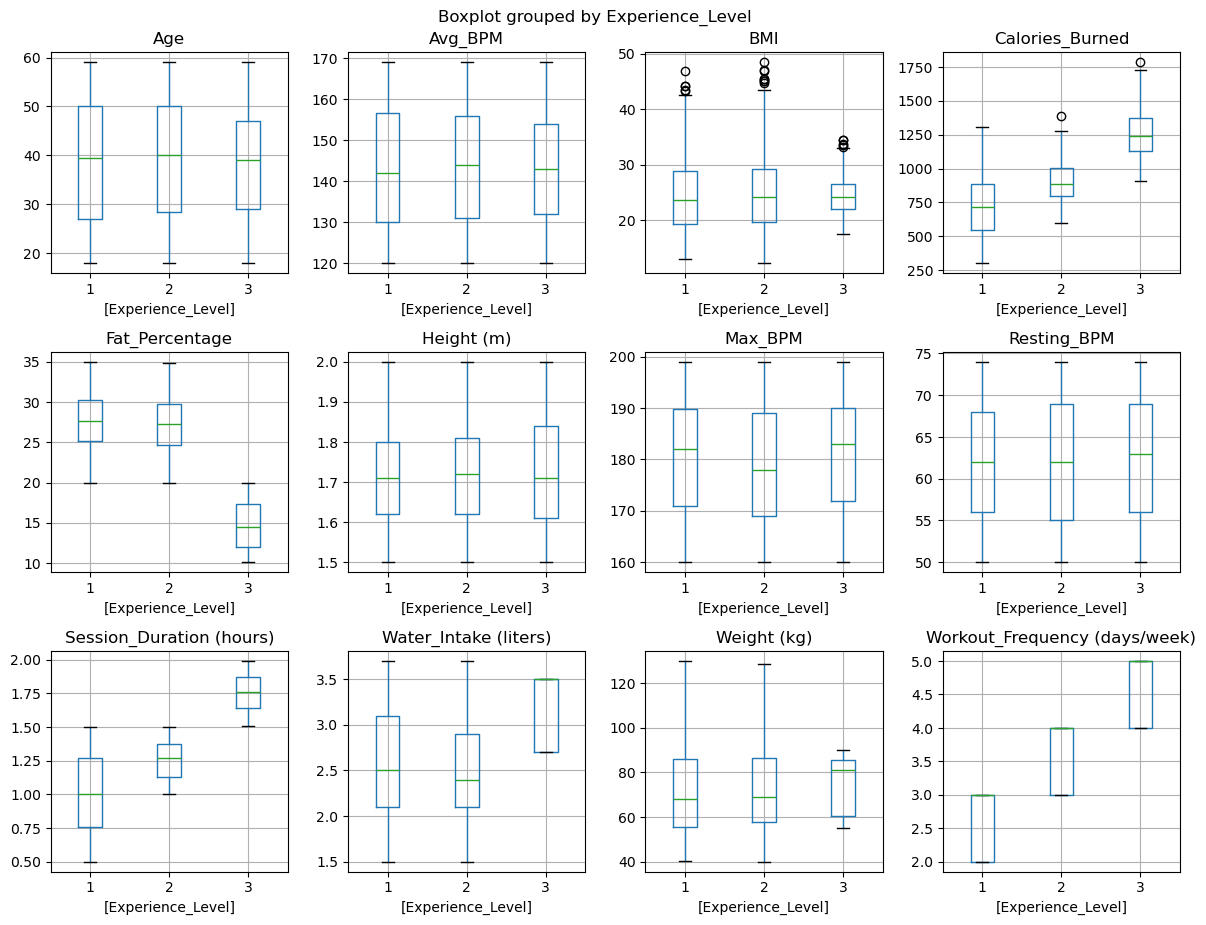

In [12]:
for cat_column in cat_columns:
    train_dataset.boxplot(by=cat_column, layout=(4, 4), sharex=False, sharey=False, figsize=(12, 12))
    plt.tight_layout()

# Parte 2: Aprendizado supervisionado

Nas questões a seguir vamos construir modelos de regressão para prever o gasto calórico em função das várias features do problema.

***

# **QUESTÕES**

***Questão 1*** (1.0 pt)

Construa um modelo do tipo LASSO para fazer seleção das features mais relevantes. Você deve:

- Fazer uma pipeline adequada para um modelo LASSO

- Testar vários valores de `alpha` até obter apenas entre 25% e 50% das features originais com pesos não-nulos.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# lasso model

from sklearn.linear_model import Lasso

# Construa um modelo do tipo LASSO para fazer seleção das features mais relevantes. Você deve:

# - Fazer uma pipeline adequada para um modelo LASSO

# - Testar vários valores de `alpha` até obter apenas entre 25% e 50% das features originais com pesos não-nulos.

alphas = [0.001, 0.01, 0.1, 1, 10, 100]
lasso = Lasso(max_iter=10000, random_state=SEED)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_columns),
        ('cat', OneHotEncoder(), cat_columns),
    ],
    remainder='passthrough',
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lasso', lasso),
])

lasso_weights = {}
lasso_alpha = None

for alpha in alphas:
    lasso.set_params(alpha=alpha)
    pipeline.fit(train_dataset.drop(columns=[target_column]), train_dataset[target_column])
    weights = pipeline.named_steps['lasso'].coef_
    non_zero_weights = len([w for w in weights if w != 0])
    total_weights = len(weights)
    lasso_weights[alpha] = non_zero_weights / total_weights
    if 0.25 <= lasso_weights[alpha] <= 0.5:
        lasso_alpha = alpha
        break

print(f'Alpha: {lasso_alpha}')
print(f'Porcentagem de features com pesos não-nulos: {lasso_weights[lasso_alpha] * 100:.2f}%')





Alpha: 10
Porcentagem de features com pesos não-nulos: 40.00%


***

# **QUESTÕES**

***Questão 2***

a) (1.0 pt) Construa um modelo do tipo "Decision Tree" e faça o ajuste de hiperparâmetros. Você deve fazer uma pipeline adequada para este tipo de modelo. Execute o ajuste para obter o melhor modelo - você é que deve determinar o `param_grid`. Mostre os parâmetros do melhor modelo e o seu respectivo desempenho médio de teste de validação cruzada (não é para usar o conjunto de teste, obviamente!).

b) (1.0 pt) Construa um modelo do tipo `sklearn.svm.LinearSVR` e faça o ajuste de hiperparâmetros. Você deve fazer uma pipeline adequada para este tipo de modelo. Execute o ajuste para obter o melhor modelo - você é que deve determinar o `param_grid`. Mostre os parâmetros do melhor modelo e o seu respectivo desempenho médio de teste de validação cruzada (não é para usar o conjunto de teste, obviamente!).

c) (1.0 pt) Construa um modelo do tipo `sklearn.ensemble.RandomForestRegressor` e faça o ajuste de hiperparâmetros. Você deve fazer uma pipeline adequada para este tipo de modelo. Execute o ajuste para obter o melhor modelo - você é que deve determinar o `param_grid`. Mostre os parâmetros do melhor modelo e o seu respectivo desempenho médio de teste de validação cruzada (não é para usar o conjunto de teste, obviamente!).

d) (1.0 pt) Construa um modelo do tipo `sklearn.dummy.DummyRegressor`. Não vai fazer ajuste de hiperparâmetros aqui. Você deve fazer uma pipeline adequada para este tipo de modelo. Execute a medida de desempenho no conjunto de treino com `cross_val_score`.

e) (0.5 pt) Para o melhor modelo dentre os itens anteriores, execute a etapa de certificação do modelo (treina no treino, testa no teste) e apresente o desempenho obtido.

f) (0.5 pt) Plote as predições versus os valores reais no conjunto de teste para ver se existe um bom ajuste.

RESPOSTAS Q2:

***

In [ ]:
# Questao A:


from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


pipeline_dt = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('tree', DecisionTreeRegressor())
])

param_grid = {
    'tree__max_depth': [2, 3, 4, 5, 6, 7, 8],
    'tree__min_samples_split': [2, 3, 4, 5, 6],
}
grid_search = GridSearchCV(
    pipeline_dt,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_search.fit(train_dataset.drop(columns=[target_column]), train_dataset[target_column])
best_params = grid_search.best_params_
best_score = grid_search.best_score_
grid_search.best_estimator_

df_results = pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_score')
df_results = df_results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].set_index('rank_test_score')

# print results

df_results.head(10)

# melhores parmetros sao: max_depth=2 e min_samples_split=2


,params,mean_test_score,std_test_score
rank_test_score,,,
1,"{'tree__max_depth': 2, 'tree__min_samples_spli...",-34979.335781,3339.011403
1,"{'tree__max_depth': 2, 'tree__min_samples_spli...",-34979.335781,3339.011403
1,"{'tree__max_depth': 2, 'tree__min_samples_spli...",-34979.335781,3339.011403
1,"{'tree__max_depth': 2, 'tree__min_samples_spli...",-34979.335781,3339.011403
1,"{'tree__max_depth': 2, 'tree__min_samples_spli...",-34979.335781,3339.011403
6,"{'tree__max_depth': 3, 'tree__min_samples_spli...",-36042.745695,2369.799031
7,"{'tree__max_depth': 3, 'tree__min_samples_spli...",-36088.508516,2434.615908
7,"{'tree__max_depth': 3, 'tree__min_samples_spli...",-36088.508516,2434.615908
7,"{'tree__max_depth': 3, 'tree__min_samples_spli...",-36088.508516,2434.615908


In [46]:
# linear svr
from sklearn.svm import LinearSVR

from sklearn.preprocessing import StandardScaler

param_grid = {
    'svr__C': [0.1, 1, 2, 3, 4, 5, 10, 20, 50, 1000000],
}

pipe = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('scaler', StandardScaler(with_mean=False)),
    ('svr', LinearSVR(max_iter=10000, random_state=SEED)),
])

grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
)

grid_search.fit(train_dataset.drop(columns=[target_column]), train_dataset[target_column])
best_params = grid_search.best_params_
best_score = grid_search.best_score_
grid_search.best_estimator_
df_results = pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_score')
df_results = df_results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].set_index('rank_test_score')
df_results.head(10)




,params,mean_test_score,std_test_score
rank_test_score,,,
1,{'svr__C': 2},-32084.705054,4353.980621
1,{'svr__C': 3},-32084.705054,4353.980621
1,{'svr__C': 4},-32084.705054,4353.980621
1,{'svr__C': 5},-32084.705054,4353.980621
1,{'svr__C': 10},-32084.705054,4353.980621
1,{'svr__C': 20},-32084.705054,4353.980621
1,{'svr__C': 50},-32084.705054,4353.980621
1,{'svr__C': 1000000},-32084.705054,4353.980621
9,{'svr__C': 1},-32084.711379,4353.928312


In [56]:
# random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

pipe = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('rf', RandomForestRegressor(random_state=SEED))
])

param_grid = {
    'rf__max_depth': [2, 3, 4, 5, 6, 7, 8],
    'rf__min_samples_leaf': [1, 2, 3, 4, 5],
}

grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
)

grid_search.fit(train_dataset.drop(columns=[target_column]), train_dataset[target_column])
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_estimator = grid_search.best_estimator_

df_results = pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_score')

df_results = df_results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].set_index('rank_test_score')
print(f'Mean Squared Error: {mse}')
df_results.head(10)

Mean Squared Error: 21517.337226384934


,params,mean_test_score,std_test_score
rank_test_score,,,
1,"{'rf__max_depth': 8, 'rf__min_samples_leaf': 2}",-32015.464782,2450.047742
2,"{'rf__max_depth': 8, 'rf__min_samples_leaf': 1}",-32123.022796,2618.551995
3,"{'rf__max_depth': 7, 'rf__min_samples_leaf': 2}",-32353.412475,2539.709431
4,"{'rf__max_depth': 7, 'rf__min_samples_leaf': 1}",-32474.761591,2725.264441
5,"{'rf__max_depth': 8, 'rf__min_samples_leaf': 3}",-32531.766240,2414.175437
6,"{'rf__max_depth': 7, 'rf__min_samples_leaf': 3}",-32680.959182,2491.704972
7,"{'rf__max_depth': 6, 'rf__min_samples_leaf': 2}",-32692.024883,2689.761601
8,"{'rf__max_depth': 6, 'rf__min_samples_leaf': 1}",-32872.489820,2702.147342
9,"{'rf__max_depth': 6, 'rf__min_samples_leaf': 3}",-32928.980748,2586.631124


In [ ]:
# dummy regressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
# cross val dummy regressor
dummy = DummyRegressor(strategy='mean')
dummy.fit(train_dataset.drop(columns=[target_column]), train_dataset[target_column])
dummy_score = cross_val_score(dummy, train_dataset.drop(columns=[target_column]), train_dataset[target_column], cv=5, scoring='neg_mean_squared_error')
dummy_score.mean(), dummy_score.std()

# print dummy score
print(f'Dummy Regressor: {dummy_score.mean():.2f} +/- {dummy_score.std():.2f}')
# print best score
print(f'Best score: {best_score:.2f} +/- {df_results["std_test_score"].min():.2f}')



Dummy Regressor: -72061.67 +/- 7003.00
Best score: -32015.46 +/- 2414.18


In [54]:
# random forest foi o melhor no treino, agora vamos testar no teste

pipe = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('rf', RandomForestRegressor(random_state=SEED, max_depth=8, min_samples_leaf=2))
])

# fit the model
pipe.fit(train_dataset.drop(columns=[target_column]), train_dataset[target_column])
# predict the test set
y_pred_test = pipe.predict(test_dataset.drop(columns=[target_column]))
y_pred_train = pipe.predict(train_dataset.drop(columns=[target_column]))
# calculate the mse
from sklearn.metrics import mean_squared_error
mse_test = mean_squared_error(test_dataset[target_column], y_pred_test)
mse_train = mean_squared_error(train_dataset[target_column], y_pred_train)
# print the mse
print(f'Train MSE: {mse_train:.2f}')
print(f'Test MSE: {mse_test:.2f}')


Train MSE: 21517.34
Test MSE: 36408.59


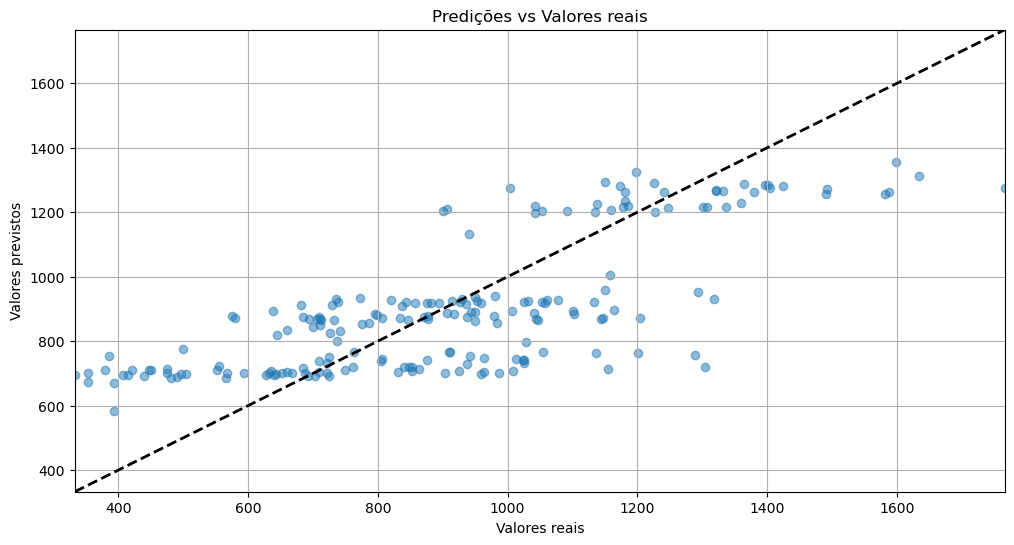

In [57]:
# plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.scatter(test_dataset[target_column], y_pred_test, alpha=0.5)
plt.plot([test_dataset[target_column].min(), test_dataset[target_column].max()],
         [test_dataset[target_column].min(), test_dataset[target_column].max()],
         'k--', lw=2)
plt.xlabel('Valores reais')
plt.ylabel('Valores previstos')
plt.title('Predições vs Valores reais')
plt.xlim(test_dataset[target_column].min(), test_dataset[target_column].max())
plt.ylim(test_dataset[target_column].min(), test_dataset[target_column].max())
plt.grid()
plt.show()

# **QUESTÕES**

***Questão 3*** Teoria

a) (0.5 pt) Explique porque a técnica de Support Vector Machines tende ao overfitting se o parâmetro de penalidade $C$ é alto, e porque tende ao underfitting se ele é baixo.

b) (0.5 pt) Explique porque em geral o *bagging* permite treinamento em paralelo e o *boosting* (qualquer um: AdaBoost, Gradient Boosting, etc) não permite

c) (0.5 pt) Explique porque uma árvore de decisão não requer normalização dos dados

RESPOSTAS Q3:

a) caso o custo de penalidade seja muito alto, a svm se torna do tipo "hard" onde nao aceita pontos dentro da "avenida" que usamos para separar nossas amostras, o modelo nao generalisa para o conjunto teste, ou caso haja pontos "misturados" sem uma separacao clara entre eles, o modelo pode nem funcionar.

por outro lado, caso o custo seja muito baixo, despresando a natureza dos dados e suas separacoes, o modelo ira ficar muito "brando", englobando muitos pontos que serao classificados de forma incorreta, fazendo com que a precision do modelo abaixe muito

b) 

c) normalizamos os dados quando temos features sendo comparadas, de forma analoga, se comparassemos features quantitativas de distancia, 

***

# Parte 3: Aprendizado não supervisionado

Nesta parte não vamos identificar nenhum *target*, nosso foco é na análise não-supervisionada do dataset completo.

***

# **QUESTÕES**

***Questão 4***

a) (0.5 pt) Construa uma pipeline que transforma o dataset completo em um dataset que apresenta valores apropriados para executar uma PCA. Por exemplo: as variáveis categóricas vão precisar de one-hot encoding. O que mais é necessário? Você deve mostrar seu conhecimento.

b) (0.5 pt) Vamos aplicar a PCA no dado transformado, com apenas 2 componentes. O código abaixo faz esse serviço para um dataset transformado `X_transf`:

```Python
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_transf)
```

Faça um scatter plot das componentes principais (as colunas de `X_pca`)

c) (1.0 pt) Execute uma clusterização com KMeans em `X_pca` para várias escolhas de k: 2, 3, 4, 5 e 6. Para cada valor de k visualize o scatter plot de `X_pca` colorido pelos *labels* de cluster. Visualmente, qual a melhor escolha? -R: k = 4

Dica: 

```Python
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_pca)
labels = kmeans.labels_
```

d) (0.5 pt) Como você usaria a informação do clustering para identificar o perfil de clientes da academia em cada cluster? Não precisa implementar, é só uma pergunta qualitativa, precisa explicar.

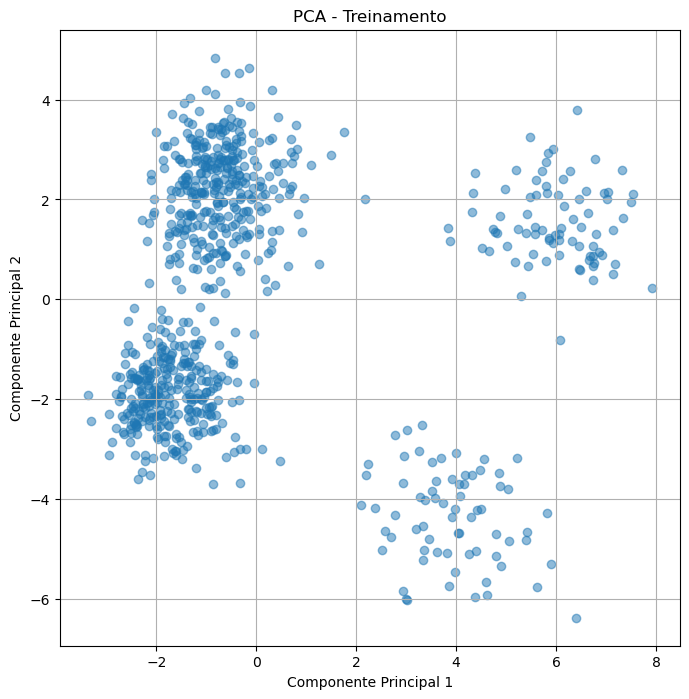

In [ ]:
from sklearn.decomposition import PCA

# onehot encoder para as categoricas obviamnte
# algum scaler, para normalizar os dados (ja que estamos lidando com distancias!!!)


pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('scaler', StandardScaler(with_mean=False)),
])

X_transf = pipeline.fit_transform(
    train_dataset.drop(columns=[target_column])
)

pca = PCA(n_components=2)

X_pca = pca.fit_transform(X_transf)


plt.figure(figsize=(8, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title('PCA - Treinamento')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid()
plt.show()




c:\Users\luigi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


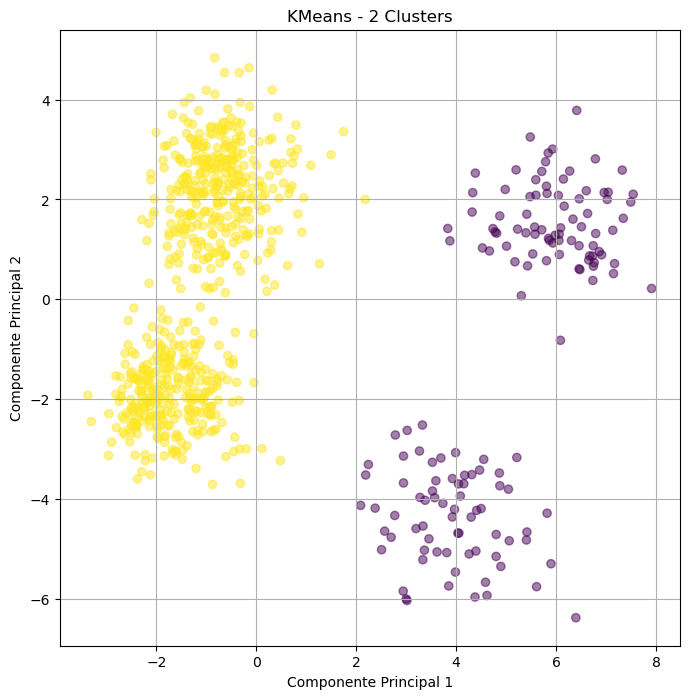

c:\Users\luigi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


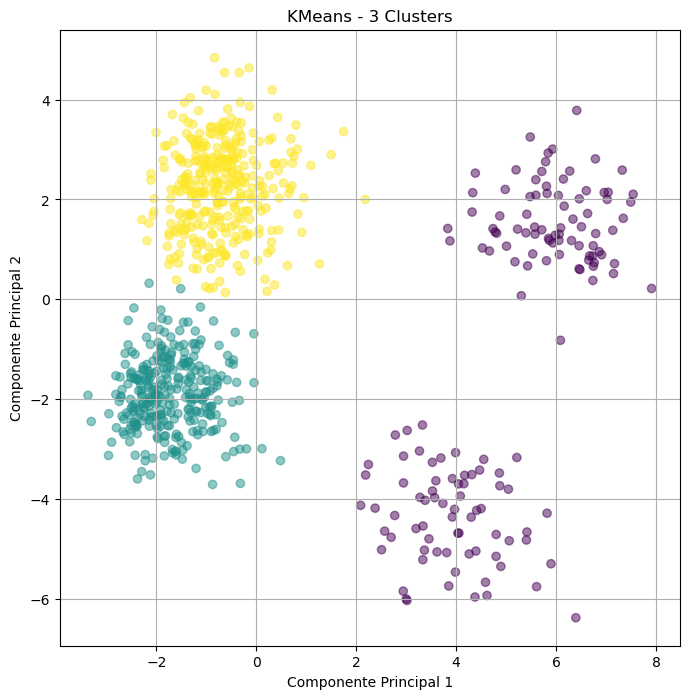

c:\Users\luigi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


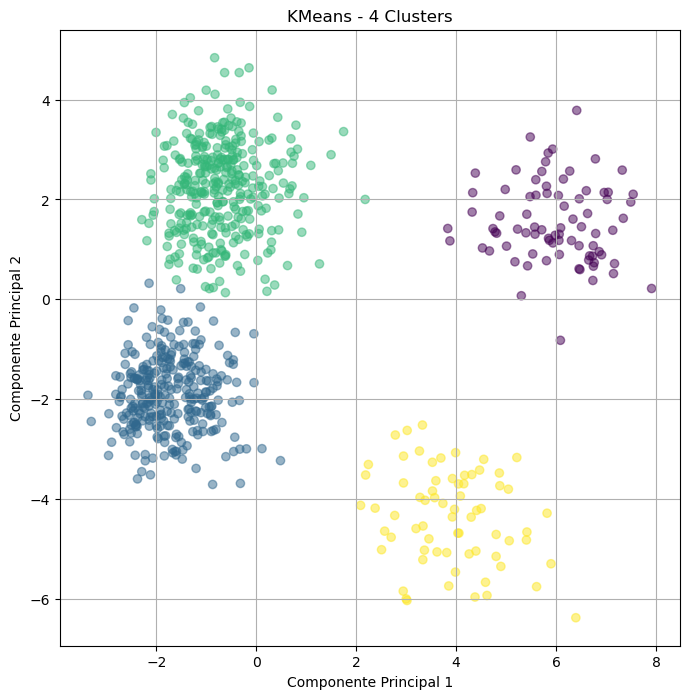

c:\Users\luigi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


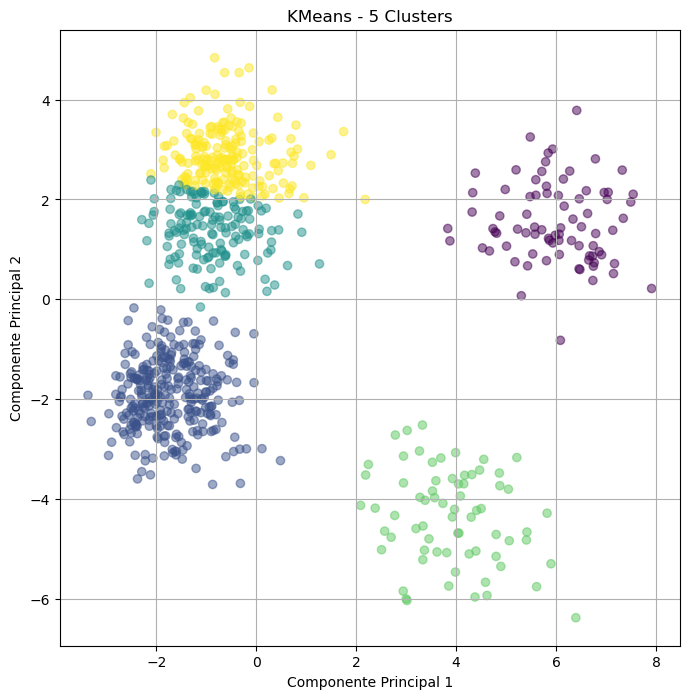

c:\Users\luigi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


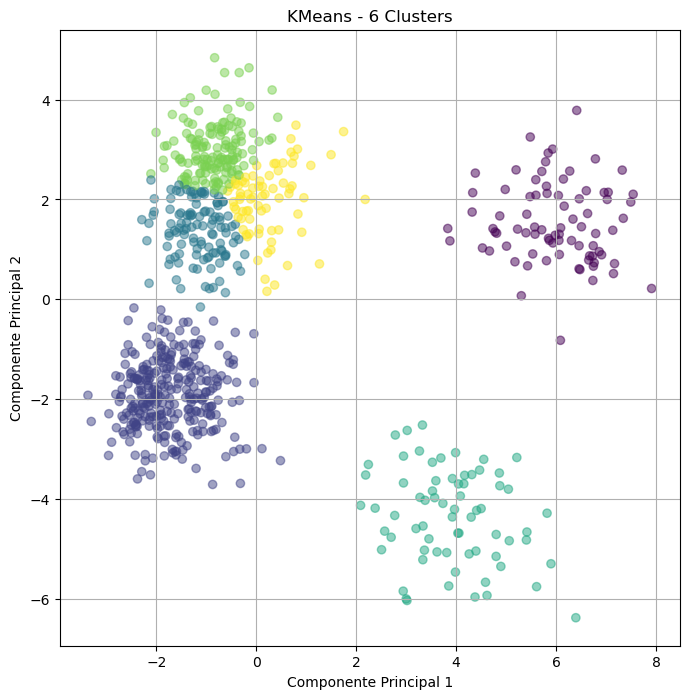

In [28]:
# usar kmeans para ver se tem clusters
from sklearn.cluster import KMeans

n_clusters = [2, 3, 4, 5, 6]
for n in n_clusters:
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(X_pca)
    labels = kmeans.labels_

    plt.figure(figsize=(8, 8))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.title(f'KMeans - {n} Clusters')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.grid()
    plt.show()

C) aparentemente a melhor escolha é K=4

D) Sim! temos 4 grupos bem definidos, o que mostra uma forte relacao entre as pessoas de mesmo grupo. alinhando esses perfis com o bussines expert, podemos ter uma analise especifica para cada grupo, o que aumenta a qualidade da informacao que podemos tirar dos dados.

***Questão bonus*** (1.0 pt)

As redes neurais já deixaram de ser primariamente inspiradas pela biologia já faz muito tempo. Hoje em dia as redes neurais são apenas funções bem flexíveis do tipo $y = f(x, \theta)$, e são aplicadas nos mais diversos contextos. Considere um par de redes neurais $f$ e $g$ para fazer o seguinte:

$$
z = f(x, \theta_f)
\hat{x} = g(z, \theta_g)
$$

Ou seja, estamos prevendo $x$ com ele mesmo! Imagine, contudo, que o número de features em $z$ é bem menor que aquele em $x$ - um gargalo de informação. Este modelo é chamado *autoencoder*, e realiza redução de dimensionalidade.

Qual a diferença entre um *autoencoder* com redes neurais e uma PCA?


se usarmos de exemplos uma foto, ambos irao reduzir a dimensionalidade ao se livrar dos dados "ruido" com menos importancia e correlacao com o resto dos dados.

pca vai tirar os dados que estao mais disconexos do vetor principal.

autoencoder vai diminuir os dados sempre que passar pelos neuronios.

Boa prova!